# Libraries

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow_docs.vis import embed

import imageio

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from IPython.display import HTML, display

# Movenet model

This model is an already trained model that extract the coordinate of the joint in each image. This part of the code is copied from https://www.tensorflow.org/hub/tutorials/movenet?hl=fr.

The "movenet_thunder" is chosen because it is the one having the best accuracy.

In [2]:
model_name = "movenet_thunder"

if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256

def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
      pixels. Note that the height/width should already be resized and match the
      expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [3]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

In [4]:
# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
    """Defines the default crop region.

    The function provides the initial crop region (pads the full image from both
    sides to make it a square image) when the algorithm cannot reliably determine
    the crop region from the previous frame.
    """
    if image_width > image_height:
        box_height = image_width / image_height
        box_width = 1.0
        y_min = (image_height / 2 - image_width / 2) / image_height
        x_min = 0.0
    else:
        box_height = 1.0
        box_width = image_height / image_width
        y_min = 0.0
        x_min = (image_width / 2 - image_height / 2) / image_width

    return {
            'y_min': y_min,
            'x_min': x_min,
            'y_max': y_min + box_height,
            'x_max': x_min + box_width,
            'height': box_height,
            'width': box_width
            }

def torso_visible(keypoints):
    """Checks whether there are enough torso keypoints.

    This function checks whether the model is confident at predicting one of the
    shoulders/hips which is required to determine a good crop region.
    """
    return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
            MIN_CROP_KEYPOINT_SCORE or
            keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
            MIN_CROP_KEYPOINT_SCORE) and
            (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
            MIN_CROP_KEYPOINT_SCORE or
            keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
            MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(keypoints, target_keypoints, center_y, center_x):
    """Calculates the maximum distance from each keypoints to the center location.

    The function returns the maximum distances from the two sets of keypoints:
    full 17 keypoints and 4 torso keypoints. The returned information will be
    used to determine the crop size. See determineCropRegion for more detail.
    """
    torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    max_torso_yrange = 0.0
    max_torso_xrange = 0.0
    for joint in torso_joints:
        dist_y = abs(center_y - target_keypoints[joint][0])
        dist_x = abs(center_x - target_keypoints[joint][1])
        if dist_y > max_torso_yrange:
            max_torso_yrange = dist_y
        if dist_x > max_torso_xrange:
            max_torso_xrange = dist_x

    max_body_yrange = 0.0
    max_body_xrange = 0.0
    for joint in KEYPOINT_DICT.keys():
        if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
            continue
        dist_y = abs(center_y - target_keypoints[joint][0]);
        dist_x = abs(center_x - target_keypoints[joint][1]);
        if dist_y > max_body_yrange:
            max_body_yrange = dist_y

        if dist_x > max_body_xrange:
            max_body_xrange = dist_x

    return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(keypoints, image_height, image_width):
    """Determines the region to crop the image for the model to run inference on.

    The algorithm uses the detected joints from the previous frame to estimate
    the square region that encloses the full body of the target person and
    centers at the midpoint of two hip joints. The crop size is determined by
    the distances between each joints and the center point.
    When the model is not confident with the four torso joint predictions, the
    function returns a default crop which is the full image padded to square.
    """
    target_keypoints = {}
    for joint in KEYPOINT_DICT.keys():
        target_keypoints[joint] = [
          keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
          keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
        ]

    if torso_visible(keypoints):
        center_y = (target_keypoints['left_hip'][0] +
                    target_keypoints['right_hip'][0]) / 2;
        center_x = (target_keypoints['left_hip'][1] +
                    target_keypoints['right_hip'][1]) / 2;

        (max_torso_yrange, max_torso_xrange,
          max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
              keypoints, target_keypoints, center_y, center_x)

        crop_length_half = np.amax(
            [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
              max_body_yrange * 1.2, max_body_xrange * 1.2])

        tmp = np.array(
            [center_x, image_width - center_x, center_y, image_height - center_y])
        crop_length_half = np.amin(
            [crop_length_half, np.amax(tmp)]);

        crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

        if crop_length_half > max(image_width, image_height) / 2:
            return init_crop_region(image_height, image_width)
        else:
            crop_length = crop_length_half * 2;
            return {
            'y_min': crop_corner[0] / image_height,
            'x_min': crop_corner[1] / image_width,
            'y_max': (crop_corner[0] + crop_length) / image_height,
            'x_max': (crop_corner[1] + crop_length) / image_width,
            'height': (crop_corner[0] + crop_length) / image_height -
                crop_corner[0] / image_height,
            'width': (crop_corner[1] + crop_length) / image_width -
                crop_corner[1] / image_width
            }
    else:
        return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
    """Crops and resize the image to prepare for the model input."""
    boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
    output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
    return output_image

def run_inference(movenet, image, crop_region, crop_size):
    """Runs model inferece on the cropped region.

    The function runs the model inference on the cropped region and updates the
    model output to the original image coordinate system.
    """
    image_height, image_width, _ = image.shape
    input_image = crop_and_resize(tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
    # Run model inference.
    keypoints_with_scores = movenet(input_image)
    # Update the coordinates.
    for idx in range(17):
        keypoints_with_scores[0, 0, idx, 0] = (
            crop_region['y_min'] * image_height +
            crop_region['height'] * image_height *
            keypoints_with_scores[0, 0, idx, 0]) / image_height
        keypoints_with_scores[0, 0, idx, 1] = (
            crop_region['x_min'] * image_width +
            crop_region['width'] * image_width *
            keypoints_with_scores[0, 0, idx, 1]) / image_width
    return keypoints_with_scores


def progress(value, max=100):
    return HTML("""<progress
                    value='{value}'
                    max='{max}',
                    style='width: 100%'
                    >
                    {value}
                    </progress>
                    """.format(value=value, max=max))

# Extraction of the coordinate

In this part, each raw video is opened and cut in smaller video according to the annotations in the "Annotations_cleaned.csv" table. The coordinate in almost each frame is saved in a CSV file. 
There is some important points to note:
- The raw videos don't have the same frame rate, and to increase the consistency in the dataset, a standardized frame rate of 15 fps is used. This is done by saving only one image every two images in a 30 fps videos for example.
- The videos of each activities don't last the same amount of time. To facilitate the use of a neural network afterwards, a total of 150 frames have been taken (which means 10s of videos because the frame rate is 15fps). Therefore, the videos that are longer than 10s are cut and the one that are shorter are looped to reach 10s.
- This part has been also used to create the test dataset from the "Annotations_test.csv" file

In [5]:
#Libraries
import os
import pandas as pd
import cv2

In [6]:
def save_coord(frames, movenet, input_size):
    """Extract and return the coordinate of each keypoint in a list of frames.
    The output is a list containing all the coordinate
    """
    #List of frames to array
    images = np.array(frames)

    #Extract the dimension of the array
    num_frames, image_height, image_width, _= images.shape
    
    #Initialize crop region 
    crop_region = init_crop_region(image_height, image_width)
    
    #Initialize used structures
    list_coord = [] #output list saving all coordinate for each frame
    bar = display(progress(0, num_frames-1), display_id=True) #creation of a progress bar


    for frame_idx in range(num_frames):
        #Find the keypoints coordinate
        keypoints_with_scores = run_inference(movenet, images[frame_idx, :, :, :], 
                                              crop_region,
                                              crop_size=[input_size, input_size])
        
        #Save the coordinate
        list_coord.append(keypoints_with_scores)

        #Update crop region
        crop_region = determine_crop_region(keypoints_with_scores, image_height, image_width)
        
        #Update progress bar
        bar.update(progress(frame_idx, num_frames-1))
    return list_coord

In [7]:
path_raw_data = 'Raw_data/'
data_info = pd.read_csv('Annotations_cleaned.csv')

indexes = [i+'_x' for i in KEYPOINT_DICT.keys()] + [i+'_y' for i in KEYPOINT_DICT.keys()] + ['Frame_number']
max_frame = 150
wanted_fps = 15
loop = False
last_video = ''
videos = list(data_info.loc[:, 'video'])
n_videos = len(videos)


for ind, video in enumerate(videos):
    
    print(str(ind+1) + '/' + str(n_videos))
    
    df = pd.DataFrame(index = indexes, columns = [str(i) for i in range(150)])
    
    frame_number = []
    frames = [] #initialize frames
    while len(frames)<max_frame:
        
        if video != last_video or loop:
            cap = cv2.VideoCapture(path_raw_data + video)
            frame_rate = cap.get(cv2.CAP_PROP_FPS)
            fps_ratio = round(frame_rate/wanted_fps)
            if fps_ratio == 0:
                fps_ratio = 1
            n = 0
            loop = False
            read = True
            
        first_frame = int(data_info.loc[ind, 'start_sec']*frame_rate)
        last_frame = int(data_info.loc[ind, 'end_sec']*frame_rate)
        
        while read and n<last_frame and len(frames)<max_frame:
            read, img = cap.read()
            if read and n>first_frame and n%fps_ratio ==0 :
                #need to save this frame
                frames.append(img)
                frame_number.append(n)
            n = n+1
            if n==last_frame:
                loop = True
    
    #Save the coordinates
    list_coord = save_coord(frames, movenet, input_size)
    
    for idx, frame in enumerate(list_coord):
        x = []
        y = []
        for i in range(17):
            x.append(frame[0,0,i,0])
            y.append(frame[0,0,i,1])
        df[str(idx)] = x+y+[int(frame_number[idx])]
    
    saving_path = './CSV_thunder/'+ data_info.loc[ind, 'label'] + '_' + str(ind) + '_' + data_info.loc[ind, 'video'].split('.mp4')[0]+'.csv'
    df.to_csv(saving_path, index =True)
    
    last_video = video


1/378


2/378


3/378


KeyboardInterrupt: 

# Check the extraction

This code is done to check that the extraction have been done properly. To do that, a random video is taken from the dataset with a random frame. This frame is displayed with small white squares at each joint accoridng to the extraction.

In [8]:
import random as rd
import os
import pandas as pd
import cv2

In [9]:
def save_coord_unique(frames, movenet, input_size):
    """Extract and return the coordinate of each keypoint in a unique frame.
    """
    image = np.array(frames)

    #Extract the dimension of the array
    image_height, image_width, _= image.shape
    
    #Initialize crop region
    crop_region = init_crop_region(image_height, image_width)
    

    keypoints_with_scores = run_inference(movenet, image[:, :, :], 
                                          crop_region,
                                          crop_size=[input_size, input_size])
    return keypoints_with_scores

In [10]:
path = './CSV_thunder/'
csv_files = [path+ file for file in os.listdir(path)]
random_file = csv_files[int((len(csv_files)-1)*rd.random())]
ind_vid = random_file.split(path)[1].split('_')[1]
video = random_file.split(path)[1].split('_'+ind_vid+'_')[1].replace('.csv', '.mp4')
print('Video checked: '+ video)

df = pd.read_csv(random_file, index_col = 0)
frame_number = int(df.loc['Frame_number', str(int(150*rd.random()))])
print('Frame checked: ' + str(frame_number))


cap = cv2.VideoCapture('Raw_data/'+ video)
n=0
read = True
while read and n<=frame_number:
        read, img = cap.read()
        if read and n==frame_number:
            image = img
        n = n+1
        
keypoints_with_scores = save_coord_unique(image, movenet, input_size)

Video checked: 3.mp4
Frame checked: 1832


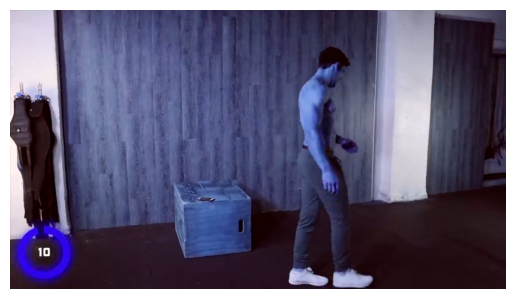

In [11]:
#Display the raw frame
plt.axis('off')
plt.imshow(image)
plt.show()

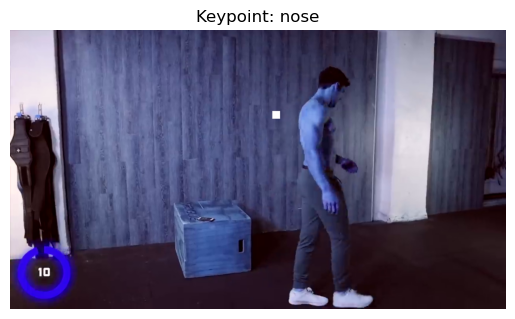

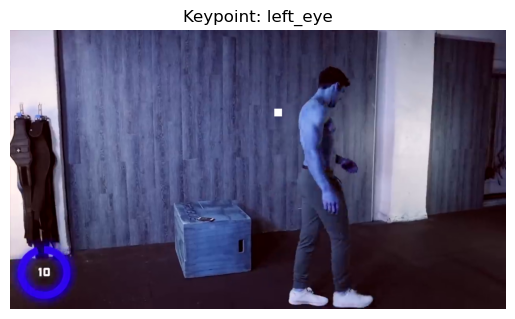

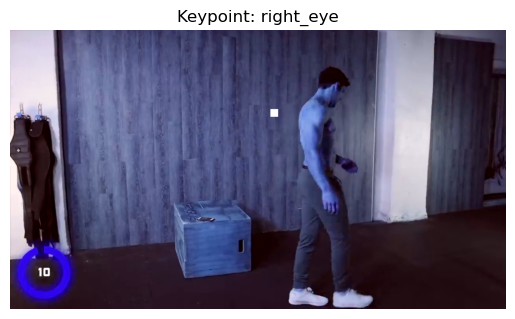

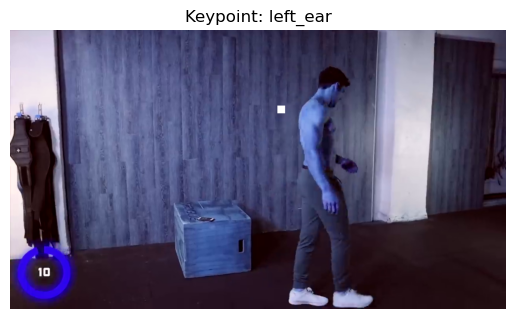

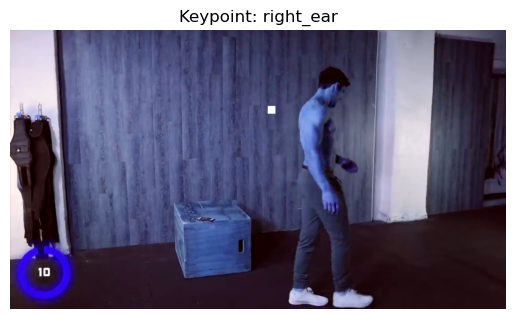

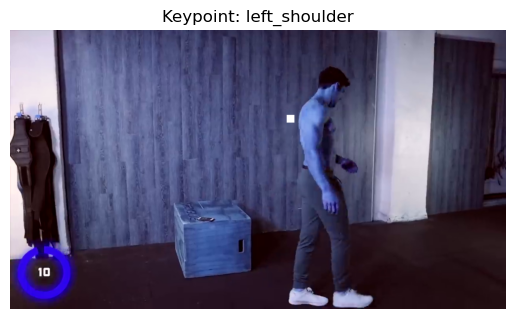

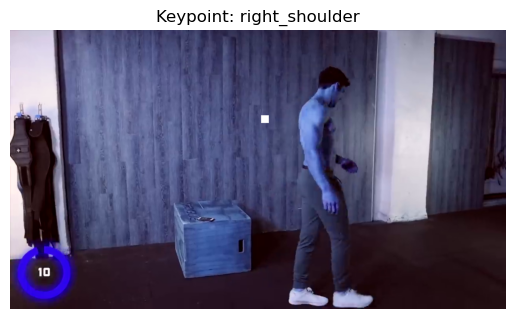

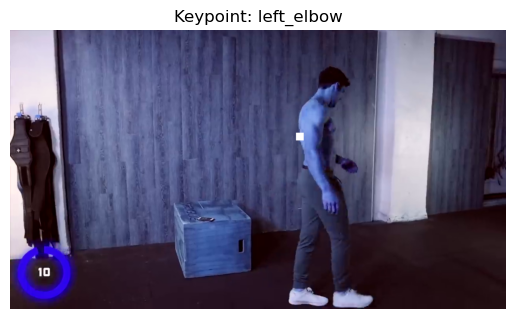

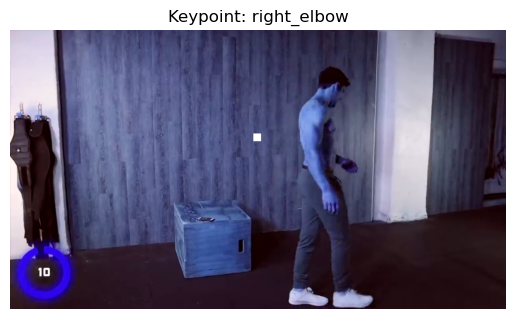

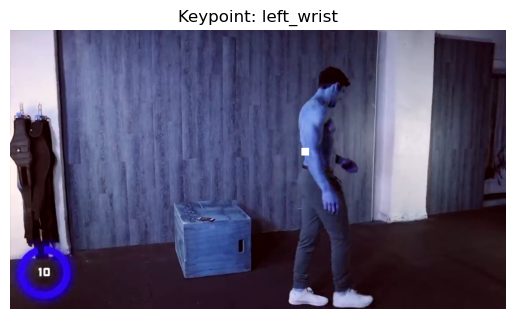

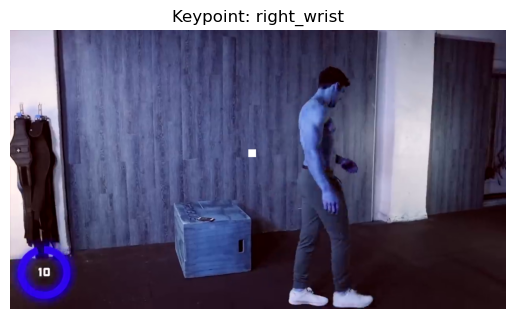

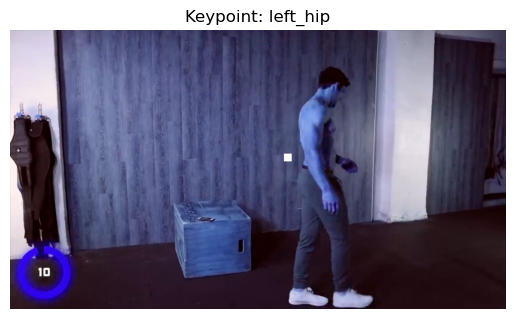

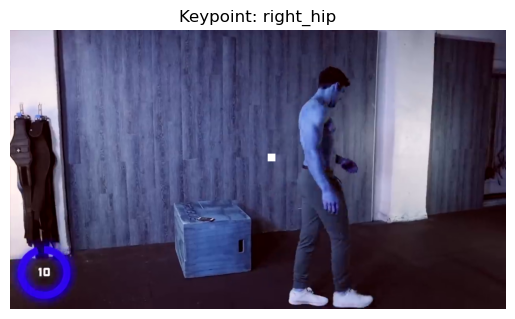

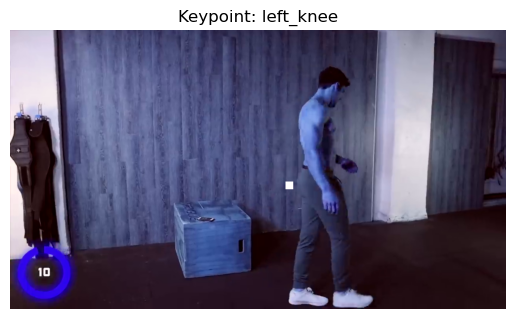

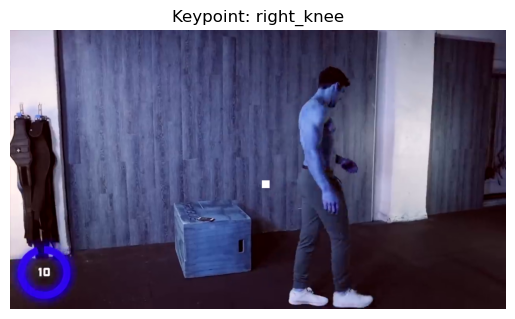

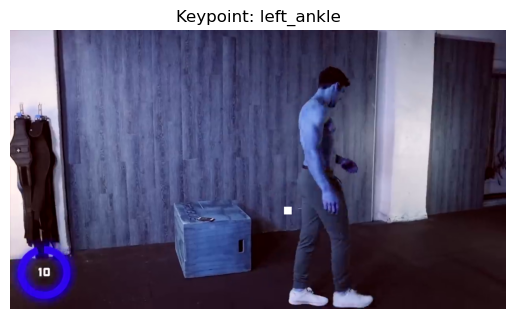

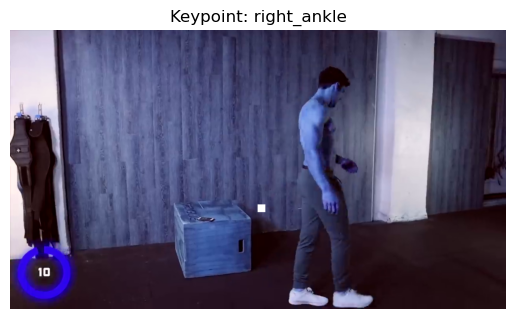

In [12]:
#Display the frame with each joint
for i, key in enumerate(KEYPOINT_DICT.keys()):
    x = df.loc[key+'_x', '110']
    y = df.loc[key+'_y', '110']
    
    image2 = image.copy()
    image2[int(x*image.shape[0])-10:int(x*image.shape[0])+10, int(y*image.shape[1])-10:int(y*image.shape[1])+10, :] = np.ones((20,20, 3))*255
    plt.figure(i)
    plt.axis('off')
    plt.title('Keypoint: '+key)
    plt.imshow(image2)
    plt.show()